# Temporal Plots of DESI Telemetry Data

As is, the DESI telemetry data is spread out across multiple different tables. As is is shown in the correlations plots in the `correlation` folder, there us very weak correlation across different tables. Before proper analysis can be done, the several datatables of interest must 
be syncronized in time. This involves rebinning and interpolation of the data is currently being hosted by NERSC.

## Imports

In [ ]:
import os
from tqdm.notebook import trange, tqdm
import pytz
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.stats import skewnorm
from scipy.stats import norm
from astropy.stats import scott_bin_width
from math import trunc
%matplotlib inline

import astropy
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.time import Time
from astropy.table import Table
from astropy.timeseries import aggregate_downsample, TimeSeries
import astropy.units as u

try:
    import numba as nb
    nb.cuda.detect()
    import cupy as cp
    %pip install -q cudf-cu11 dask-cudf-cu11 --extra-index-url=https://pypi.ngc.nvidia.com
    import cudf as cd
    gpu_access = True
except:
    gpu_access = False
    print('No GPU devices available!')
data_dir = '../../py/desiforecast/data'

## Load Data

In [ ]:
tower_data = TimeSeries.read(f'{data_dir}/environmentmonitor_tower.fits')
dome_data = TimeSeries.read(f'{data_dir}/environmentmonitor_dome.fits')
telescope_data = TimeSeries.read(f'{data_dir}/environmentmonitor_telescope.fits')
seeing_data = TimeSeries.read(f'{data_dir}/etc_seeing.fits')
telemetry_data = TimeSeries.read(f'{data_dir}/etc_telemetry.fits')
tcs_data = TimeSeries.read(f'{data_dir}/tcs_info.fits')

In [ ]:
# Original, unfiltered data as provided by the DESI telemetry database
with open(f'{data_dir}/environmentmonitor_tower.pkl', 'rb') as pf:
    tower_data = pd.read_pickle(pf)
with open(f'{data_dir}/environmentmonitor_dome.pkl', 'rb') as pf:
    dome_data = pd.read_pickle(pf)
with open(f'{data_dir}/environmentmonitor_telescope.pkl', 'rb') as pf:
    telescope_data = pd.read_pickle(pf)
    telescope_data['mirror_cooling'] = telescope_data['mirror_cooling'].interpolate(limit_direction='both')
with open(f'{data_dir}/etc_seeing.pkl', 'rb') as pf:
    seeing_data = pd.read_pickle(pf)
with open(f'{data_dir}/etc_telemetry.pkl', 'rb') as pf:
    telemetry_data = pd.read_pickle(pf)
with open(f'{data_dir}/tcs_info.pkl', 'rb') as pf:
    tcs_data = pd.read_pickle(pf)
with open(f'{data_dir}/temp_delta_stats_daytime.pkl', 'rb') as pf:
    daytime_delta_stats_data = pd.read_pickle(pf)
with open(f'{data_dir}/temp_delta_stats_nighttime.pkl', 'rb') as pf:
    nighttime_delta_stats_data = pd.read_pickle(pf)
with open(f'{data_dir}/temp_delta_stats_nighttime.pkl', 'rb') as pf:
    nighttime_delta_stats_data = pd.read_pickle(pf)
with open(f'{data_dir}/full_distributions_daytime.pkl', 'rb') as pf:
    full_distributions_daytime = pd.read_pickle(pf)
with open(f'{data_dir}/full_distributions_nighttime.pkl', 'rb') as pf:
    full_distributions_nighttime = pd.read_pickle(pf)

In [10]:
with open(f'{data_dir}/ambient_distributions_daytime.pkl', 'rb') as pf:
    ambient = pd.read_pickle(pf)
with open(f'{data_dir}/delta_distributions_daytime.pkl', 'rb') as pf:
    delta = pd.read_pickle(pf)

In [ ]:
print(ambient[2022][9])

In [91]:
from matplotlib import cm
from datetime import datetime

def distributions_over_time(daytime):
    folder = 'daytime' if daytime else 'nighttime'
    years = [2019, 2020, 2021, 2022, 2023]
    months = np.linspace(1, 12, 12, dtype=np.int64)
    std_temps1 = np.linspace(-10, 30, 4001)
    std_temps2 = np.linspace(-20, 20, 4001)
    
    with open(f'{data_dir}/ambient_distributions_{folder}.pkl', 'rb') as pf:
        ambient = pd.read_pickle(pf)
    with open(f'{data_dir}/delta_distributions_{folder}.pkl', 'rb') as pf:
        delta = pd.read_pickle(pf)
    
    ambient_distr = []
    ambient_times = []
    delta_distr = []
    delta_times = []
    for i in years:
        for j in tqdm(months, desc=f'{i}'):
            if len(ambient[i][j]):
                ambient[i][j] = [k for k in ambient[i][j] if not (k != k) ]
                if len(ambient[i][j]):
                    ambient_distr.append(skewnorm.pdf(std_temps1, *skewnorm.fit(ambient[i][j])))
                    ambient_times.append(f'{i}-{j}')
            if len(delta[i][j]):
                delta[i][j] = [k for k in delta[i][j] if not (k != k) ]
                if len(delta[i][j]):
                    delta_distr.append(skewnorm.pdf(std_temps2, *skewnorm.fit(delta[i][j])))
                    delta_times.append(f'{i}-{j}')

    ambient_distr = np.asarray(ambient_distr)
    ambient_times = np.asarray(ambient_times)
    delta_distr = np.asarray(delta_distr)
    delta_times = np.asarray(delta_times)

    temp_nums = np.linspace(1, len(ambient_times), len(ambient_times))
    XX, YY = np.meshgrid(temp_nums, std_temps1)

    ax = plt.figure().add_subplot(projection='3d')
    ax.view_init(60, 15)
    surf = ax.plot_surface(XX, YY, ambient_distr.T, cmap=cm.plasma, lw=0.5, rstride=8, cstride=8)
    fig.colorbar(surf, shrink=0.5, aspect=5, ax=ax)
    ax.set_title('Ambient Temperature Distribution as a Function of Time')
    ax.set_xlabel('Date')
    ax.set_ylabel(u'Ambient Temperature (\u2103)')
    ax.set_zlabel('Density (%)')
    
    ax.set_xticks([temp_nums[0], temp_nums[len(temp_nums)//4], temp_nums[len(temp_nums)//2], temp_nums[3*len(temp_nums)//4], temp_nums[-1]]) 
    ax.set_xticklabels([ambient_times[0], ambient_times[len(ambient_times)//4], ambient_times[len(ambient_times)//2], ambient_times[3*len(ambient_times)//4], ambient_times[-1]])
    plt.savefig(f'time_plots/temp_distributions/ambient_distribution_{folder}.png')
    
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['figure.facecolor'] = 'white'
    plt.show()

    temp_nums = np.linspace(1, len(delta_times), len(delta_times))
    XX, YY = np.meshgrid(temp_nums, std_temps2)

    ax = plt.figure().add_subplot(projection='3d')
    ax.view_init(45, 35)
    surf = ax.plot_surface(XX, YY, delta_distr.T, cmap=cm.plasma, lw=0.5, rstride=8, cstride=8)
    fig.colorbar(surf, shrink=0.5, aspect=5, ax=ax)
    ax.set_title('Temperature Delta Distribution as a Function of Time')
    ax.set_xlabel('Date')
    ax.set_ylabel(u'Temperature Delta (\u2103)')
    ax.set_zlabel('Density (%)')
    
    ax.set_xticks([temp_nums[0], temp_nums[len(temp_nums)//4], temp_nums[len(temp_nums)//2], temp_nums[3*len(temp_nums)//4], temp_nums[-1]]) 
    ax.set_xticklabels([delta_times[0], delta_times[len(delta_times)//4], delta_times[len(delta_times)//2], delta_times[3*len(delta_times)//4], delta_times[-1]])
    plt.savefig(f'time_plots/temp_distributions/delta_distribution_{folder}.png')
    
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['figure.facecolor'] = 'white'
    plt.show()


2019:   0%|          | 0/12 [00:00<?, ?it/s]

2020:   0%|          | 0/12 [00:00<?, ?it/s]

2021:   0%|          | 0/12 [00:00<?, ?it/s]

/global/common/software/desi/perlmutter/desiconda/20220119-2.0.1/conda/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1833: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


2022:   0%|          | 0/12 [00:00<?, ?it/s]

2023:   0%|          | 0/12 [00:00<?, ?it/s]

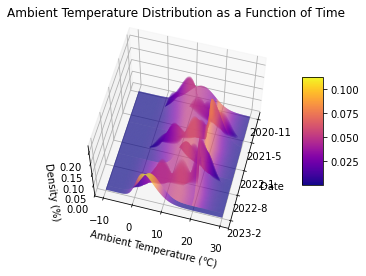

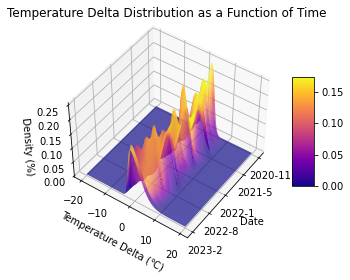

2019:   0%|          | 0/12 [00:00<?, ?it/s]

/global/common/software/desi/perlmutter/desiconda/20220119-2.0.1/conda/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1833: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


2020:   0%|          | 0/12 [00:00<?, ?it/s]

2021:   0%|          | 0/12 [00:00<?, ?it/s]

2022:   0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
distributions_over_time(daytime=True)
distributions_over_time(daytime=False)

In [ ]:
print(np.max(ambient_distributions))

In [ ]:
def resample_data(df):
    """Resamples DESI telemetry data contained within Pandas dataframe.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Original data as queried from the DESI telemetry database
    
    Returns
    -------
    df : pandas.DataFrame
        Resampled and interpolated DESI telemetry data
    """
    if 'seeing' in df.columns.values:
        pass
    else:
        df = df.resample('6S').mean()
        df.interpolate(limit_direction='both', inplace=True)
    df = df.tz_convert("America/Phoenix")
    return df

In [ ]:
# tower_data = resample_data(tower_data)
# dome_data = resample_data(dome_data)
# telescope_data = resample_data(telescope_data)
# seeing_data = resample_data(seeing_data)
# telemetry_data = resample_data(telemetry_data)
# tcs_data = resample_data(tcs_data)

In [ ]:
print(tower_data.notnull().all())
print(dome_data.notnull().all())
print(telescope_data.notnull().all())
print(seeing_data.notnull().all())
print(telemetry_data.notnull().all())
print(tcs_data.notnull().all())
print(daytime_delta_stats_data.notnull().all())
print(nighttime_delta_stats_data.notnull().all())


In [7]:
from scipy import stats
# removes results outside of 5 std
def remove_outliers(data):
    return np.logical_and(np.argwhere(np.abs(stats.zscore(data.to_numpy())) < 5), np.argwhere(data.notnull()))

In [ ]:
def yearly_delta_stats(daytime=True):
    temp_delta_data = daytime_delta_stats_data if daytime else nighttime_delta_stats_data
    folder = 'daytime' if daytime else 'nighttime'
    directory = f'time_plots/temp_statistics/{folder}'
    if not os.path.isdir(directory):
        os.makedirs(directory)
    years = [2019, 2020, 2021, 2022, 2023]
    months = np.linspace(1, 12, 12, dtype=np.int64)
    no_outliers = remove_outliers(temp_delta_data['mean'])
    for i in years:
        for j in months:
            valid = np.argwhere(np.logical_and(temp_delta_data.index[no_outliers].year == i, temp_delta_data.index[no_outliers].month == j)).flatten()
            if len(valid):
                fig, ax = plt.subplots(figsize=(20,15))
                plt.rcParams['axes.facecolor']='white'
                plt.rcParams['savefig.facecolor']='white'
                plt.rcParams['figure.facecolor'] = 'white'
                ax.set_title('Daily Temperature Statistics vs. Date/Time')
                ax.set_xlabel('Day')
                ax.autoscale(True)
                ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['mins'].iloc[no_outliers][valid], label='daily minimum')
                ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['maxs'].iloc[no_outliers][valid], label='daily maximum')
                ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['mean'].iloc[no_outliers][valid], label='daily mean')
                ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['median'].iloc[no_outliers][valid], label='daily median')
                ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['std'].iloc[no_outliers][valid], label='daily std')
                ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['var'].iloc[no_outliers][valid], label='daily var')
                ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['start'].iloc[no_outliers][valid], label='daily start temp')
                ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['end'].iloc[no_outliers][valid], label='daily end temp')
                ax.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['ambient_when_equal'].iloc[no_outliers][valid], label='daily ambient when temp equalized')
                ax_handles, _ = ax.get_legend_handles_labels()
                twin = ax.twinx()
                twin.set_ylabel('Hours For Temperature To Equalize')
                twin.autoscale(True)
                twin.plot(temp_delta_data.index[no_outliers][valid], temp_delta_data['equalize_time'].iloc[no_outliers][valid], c='maroon', label='time to equalize')
                twin_handles, _ = twin.get_legend_handles_labels()
                ax.legend(handles=ax_handles+twin_handles)

                fig.savefig(f'{directory}/{i}-{j}.png')
                plt.close(fig)

In [ ]:
yearly_delta_stats(daytime=True)
yearly_delta_stats(daytime=False)

## 02/09/23 Tasks
- Plot for every month
    - Get delta temp when mirror cooling is off
        - ~~1d distribution for each month~~
        - 3d plot of all months
    - Get time it reach desired temp during mirror cooling
        - ~~as a function of ambient temperature at start~~
        - ~~as a function of air temperature variance~~
        - percent of time outside of ideal window~~
    - ~~Ambient air during mirror cooling~~   
- how often operators follow forecasts of the night
- how accurate are the forecasts and to what degree
- March 8, desi movie in Oakland hills

## Single Day Temperature Plots (Night vs Day)

In [ ]:
def new_temperature_plot(year=2022, month=9, day=24, offset=1, save=False):
    start_date = pd.Timestamp(year=year,month=month,day=day,hour=17, minute=0, second=0, microsecond=0, tz="America/Phoenix")-pd.DateOffset(day=1)
    end_date = start_date+pd.DateOffset(day=offset)
    if gpu_access:
        start_date = start_date.to_numpy()
        end_date = end_date.to_numpy()

    print(f'Start date: {start_date}')
    print(f'Offset length (# of days): {offset}')
    
    fig, ax = plt.subplots(ncols=2, figsize=(20,10))
    ax0_plots = []
    ax1_plots = []
    ax[0].autoscale(True)
    ax[0].set_title('Mirror Temperature & Seeing vs. Date/Time')
    ax[0].set_ylabel('Mirror Temperature (Celcius)')
    ax[0].set_xlabel('Date/Time')
    ax[1].autoscale(True)
    ax[1].set_title('Dome & Tower Temperature vs. Date/Time')
    ax[1].set_ylabel('Dome Temperature (Celcius)')
    ax[1].set_xlabel('Date/Time')

    if gpu_access:
        telescope_indicies = cp.argwhere(cp.logical_and(telescope_data.index >= start_date, telescope_data.index <= end_date)).flatten()
    else:
        telescope_indicies = np.argwhere(np.logical_and(telescope_data.index >= start_date, telescope_data.index <= end_date)).flatten()
    temp_delta = remove_outliers(telescope_data.iloc[telescope_indicies]['air_temp']-telescope_data.iloc[telescope_indicies]['mirror_temp'])
    print(f'Number of valid telescope environment samples in current time window: {len(telescope_indicies)}')
    if len(telescope_indicies):
        ax0_plots.append(ax[0].plot(telescope_data.index[telescope_indicies], telescope_data.iloc[telescope_indicies]['mirror_avg_temp'], label='average mirror temp')[0])
        ax0_plots.append(ax[0].plot(telescope_data.index[telescope_indicies], telescope_data.iloc[telescope_indicies]['mirror_temp'], label='mirror temp')[0])
        ax0_plots.append(ax[0].plot(telescope_data.index[telescope_indicies], telescope_data.iloc[telescope_indicies]['mirror_desired_temp'], label='desired mirror temp')[0])
        ax0_plots.append(ax[0].plot(telescope_data.index[telescope_indicies], telescope_data.iloc[telescope_indicies]['air_temp'], label='air temp')[0])
        ax0_plots.append(ax[0].plot(telescope_data.index[telescope_indicies], telescope_data.iloc[telescope_indicies]['mirror_cooling'], label='mirror cooling')[0])
        ax0_plots.append(ax[0].plot(temp_delta.index, temp_delta, label='temp delta')[0])
        ax[0].axhline(y=1.5, color='maroon', linestyle='--')
        ax[0].axhline(y=-1.5, color='maroon', linestyle='--')
        ax[0].annotate(u"1.5 \u2103", xy=(end_date, 1.75), annotation_clip=False, ha='right')
        ax[0].annotate(u"-1.5 \u2103", xy=(end_date, -1.25), annotation_clip=False, ha='right')

    if gpu_access:
        telemetry_indicies = cp.argwhere(cp.logical_and(telemetry_data.index >= start_date, telemetry_data.index <= end_date)).flatten()
    else:
        telemetry_indicies = np.argwhere(np.logical_and(telemetry_data.index >= start_date, telemetry_data.index <= end_date)).flatten()
    print(f'Number of valid etc telemetry samples in current time window: {len(telemetry_indicies)}')
    if len(telemetry_indicies):
        twin0 = ax[0].twinx()
        ax0_plots.append(twin0.plot(telemetry_data.index[telemetry_indicies], telemetry_data.iloc[telemetry_indicies]['seeing'], color="indigo", label='seeing')[0])
        twin0.autoscale(True)
        twin0.set_ylabel('Seeing')

    if gpu_access:
        dome_indicies = cp.argwhere(cp.logical_and(dome_data.index >= start_date, dome_data.index <= end_date)).flatten()
    else:
        dome_indicies = np.argwhere(np.logical_and(dome_data.index >= start_date, dome_data.index <= end_date)).flatten()
    print(f'Number of valid dome environment samples in current time window: {len(dome_indicies)}')
    if len(dome_indicies):
        ax1_plots.append(ax[1].plot(dome_data.index[dome_indicies], dome_data.iloc[dome_indicies]['dome_floor_ne'], label='dome floor temp (NE)')[0])
        ax1_plots.append(ax[1].plot(dome_data.index[dome_indicies], dome_data.iloc[dome_indicies]['dome_floor_nw'], label='dome floor temp (NW)')[0])
        ax1_plots.append(ax[1].plot(dome_data.index[dome_indicies], dome_data.iloc[dome_indicies]['dome_floor_s'], label='dome floor temp (S)')[0])

    if gpu_access:
        tower_indicies = cp.argwhere(cp.logical_and(tower_data.index >= start_date, tower_data.index <= end_date)).flatten()
    else:
        tower_indicies = np.argwhere(np.logical_and(tower_data.index >= start_date, tower_data.index <= end_date)).flatten()
    print(f'Number of valid tower environment samples in current time window: {len(tower_indicies)}')
    if len(tower_indicies):
        twin1 = ax[1].twinx()
        ax1_plots.append(twin1.plot(tower_data.index[tower_indicies], tower_data.iloc[tower_indicies]['temperature'], color="indigo", label='tower temp')[0])
        twin1.autoscale(True)
        twin1.set_ylabel('Tower Temperature (Celcius)')
    
    if ax1_plots:
        ax[1].legend(handles=ax1_plots)
    else:
        ax[1].remove()

    if ax0_plots:
        ax[0].legend(handles=ax0_plots)
        if save:
            plt.savefig(f'time_plots/with_temp_delta/{year}-{month}-{day}_{offset}-day-offset.png', format='png')
        plt.show()
    else:
        print("Insufficient data in this time window!")

In [ ]:
def get_time_ranges(cooling_on):
    changes = telescope_data['mirror_cooling'][1:].to_numpy()-telescope_data['mirror_cooling'][:len(telescope_data)-1].to_numpy()
    changes = changes[remove_outliers(telescope_data['air_temp'][:-1])]
    ranges = []
    start=0
    for i in range(len(changes)):
        if cooling_on:
            if changes[i] == 1:
                start = i
            elif changes[i] == -1:
                end = i
                ranges.append(np.linspace(start+1, end, end-start, dtype=np.int64))
        else:
            if changes[i] == -1:
                start = i
            elif changes[i] == 1:
                end = i
                ranges.append(np.linspace(start+1, end, end-start, dtype=np.int64))
    return ranges

In [ ]:
def temp_delta_stats(daytime=True):
    file = 'daytime' if daytime else 'nighttime'
    time_ranges = get_time_ranges(cooling_on=daytime)
    mirror_ambient_delta = telescope_data['air_temp']-telescope_data['mirror_temp']
    mirror_desired_delta = telescope_data['mirror_desired_temp']-telescope_data['mirror_temp']
    df = pd.DataFrame()
    mins = []
    maxs = []
    mean = []
    median = []
    std = []
    var = []
    start = []
    end = []
    start_time = []
    equalize_time = []
    ambient_when_equal = []
    for i in trange(len(time_ranges), desc=f'{file} statistics'):
        mins.append(mirror_ambient_delta.iloc[time_ranges[i]].min())
        maxs.append(mirror_ambient_delta.iloc[time_ranges[i]].max())
        mean.append(mirror_ambient_delta.iloc[time_ranges[i]].mean())
        median.append(mirror_ambient_delta.iloc[time_ranges[i]].median())
        std.append(mirror_ambient_delta.iloc[time_ranges[i]].std())
        var.append(mirror_ambient_delta.iloc[time_ranges[i]].var())
        start.append(mirror_ambient_delta.iloc[time_ranges[i][0]])
        end.append(mirror_ambient_delta.iloc[time_ranges[i][-1]])
        start_time.append(mirror_ambient_delta.index[time_ranges[i]][0])
        equalize = np.argwhere(mirror_ambient_delta.iloc[time_ranges[i]].to_numpy()<1e-2).flatten()
        if len(equalize):
            time = (mirror_ambient_delta.index[time_ranges[i]][equalize[-1]]-mirror_ambient_delta.index[time_ranges[i]][-1]).seconds/3600
            equalize_time.append(time)
            ambient_when_equal.append(telescope_data.iloc[time_ranges[i]]['air_temp'][equalize[-1]])
        else:
            equalize_time.append(None)
            ambient_when_equal.append(None)
    df['mins'] = mins
    df['maxs'] = maxs
    df['mean'] = mean
    df['median'] = median
    df['std'] = std
    df['var'] = var
    df['start'] = start
    df['end'] = end
    df['start_time'] = start_time
    df['equalize_time'] = equalize_time
    df['ambient_when_equal'] = ambient_when_equal
    df.set_index('start_time', inplace=True)
    with open(f'{data_dir}/temp_delta_stats_{file}.pkl', 'wb') as pf:
        pickle.dump(df, pf)

In [ ]:
temp_delta_stats(daytime=True)
temp_delta_stats(daytime=False)

In [ ]:
def mirror_cooling_plots(daytime=False):
    time_ranges = get_time_ranges(cooling_on=daytime)
    mirror_ambient_delta = telescope_data['air_temp']-telescope_data['mirror_temp']
    mirror_desired_delta = telescope_data['mirror_desired_temp']-telescope_data['mirror_temp']
    folder = 'daytime' if daytime else 'nighttime'

    for i in trange(len(time_ranges), desc=f'{folder} single day plots'):
                
        fig, ax = plt.subplots(ncols=2, figsize=(20,10))
        ax0_plots = []
        ax1_plots = []
        ax[0].autoscale(True)
        ax[0].set_title('Mirror Temperature vs. Date/Time')
        ax[0].set_ylabel('Mirror Temperature (Celcius)')
        ax[0].set_xlabel('Date/Time')
        ax[1].autoscale(True)
        ax[1].set_title('Dome & Tower Temperature vs. Date/Time')
        ax[1].set_ylabel('Dome Temperature (Celcius)')
        ax[1].set_xlabel('Date/Time')
    
        fig.autofmt_xdate()        

        ax[0].plot(telescope_data.index[time_ranges[i]], telescope_data.iloc[time_ranges[i]]['mirror_avg_temp'], label='average mirror temp')
        ax[0].plot(telescope_data.index[time_ranges[i]], telescope_data.iloc[time_ranges[i]]['mirror_temp'], label='mirror temp')
        ax[0].plot(telescope_data.index[time_ranges[i]], telescope_data.iloc[time_ranges[i]]['mirror_desired_temp'], label='desired mirror temp')
        ax[0].plot(telescope_data.index[time_ranges[i]], telescope_data.iloc[time_ranges[i]]['air_temp'], label='air temp')
        ax[0].plot(telescope_data.index[time_ranges[i]], telescope_data.iloc[time_ranges[i]]['mirror_cooling'], label='mirror cooling')
        ax[0].plot(mirror_ambient_delta.index[time_ranges[i]], mirror_ambient_delta.iloc[time_ranges[i]], label='ambient & mirror temp delta')
        ax[0].plot(mirror_desired_delta.index[time_ranges[i]], mirror_desired_delta.iloc[time_ranges[i]], label='desired & mirror temp delta')
        ax[0].axhline(y=1.5, color='maroon', linestyle='--')
        ax[0].axhline(y=-1.5, color='maroon', linestyle='--')
        ax[0].annotate(u"1.5 \u2103", xy=(telescope_data.index[time_ranges[i]][-1], 1.75), annotation_clip=False, ha='right')
        ax[0].annotate(u"-1.5 \u2103", xy=(telescope_data.index[time_ranges[i]][-1], -1.25), annotation_clip=False, ha='right')

        if not daytime:
            telemetry_indicies = np.argwhere(np.logical_and(telemetry_data.index >= telescope_data.index[time_ranges[i]][0], telemetry_data.index <= telescope_data.index[time_ranges[i]][-1])).flatten()
            if len(telemetry_data.iloc[telemetry_indicies]['seeing']):
                twin0 = ax[0].twinx()
                ax[0].set_title('Mirror Temperature & Seeing vs. Date/Time')
                twin0.set_ylabel('Seeing')
                twin0.autoscale(True)
                twin0.plot(telemetry_data.index[telemetry_indicies], telemetry_data.iloc[telemetry_indicies]['seeing'], color="indigo", label='seeing')

        ax[1].plot(dome_data.index[time_ranges[i]], dome_data.iloc[time_ranges[i]]['dome_floor_ne'], label='dome floor temp (NE)')
        ax[1].plot(dome_data.index[time_ranges[i]], dome_data.iloc[time_ranges[i]]['dome_floor_nw'], label='dome floor temp (NW)')
        ax[1].plot(dome_data.index[time_ranges[i]], dome_data.iloc[time_ranges[i]]['dome_floor_s'], label='dome floor temp (S)')

        twin1 = ax[1].twinx()
        twin1.plot(tower_data.index[time_ranges[i]], tower_data.iloc[time_ranges[i]]['temperature'], color="indigo", label='tower temp')
        twin1.autoscale(True)
        twin1.set_ylabel('Tower Temperature (Celcius)')

        ax[0].legend(handles=ax[0].get_legend_handles_labels()+twin0.get_legend_handles_labels())
        ax[1].legend(handles=ax[1].get_legend_handles_labels()+twin1.get_legend_handles_labels())

        year = telescope_data.index[time_ranges[i]][0].year
        month = telescope_data.index[time_ranges[i]][0].month
        day = telescope_data.index[time_ranges[i]][0].day
        plt.rcParams['axes.facecolor']='white'
        plt.rcParams['savefig.facecolor']='white'
        plt.rcParams['figure.facecolor'] = 'white'
        fig.savefig(f'time_plots/single_day_plots/{folder}/{year}-{month}-{day}.png')
        plt.close(fig)

In [ ]:
mirror_cooling_plots(daytime=True)
mirror_cooling_plots(daytime=False)

In [ ]:
for i in range(len(telescope_data['air_temp'])):
    if telescope_data['air_temp'][i] is pd.NA or np.nan:
        print(i)

In [ ]:
print(type(telescope_data['air_temp'].index[0]))
print(type(np.linspace(1, 50)))
print(telescope_data['air_temp'].index[0])
print(telescope_data['air_temp'].index[0].date())


## Monthly Temperature Delta Distributions

In [8]:


def temp_distribution_data(daytime=True):
    folder = 'daytime' if daytime else 'nighttime'
    time_ranges = get_time_ranges(cooling_on=daytime)[:-1]
    ambient_mirror_delta = telescope_data['air_temp']-telescope_data['mirror_temp']
    ambient_mirror_delta = ambient_mirror_delta[remove_outliers(ambient_mirror_delta)]
    ambient_temp = telescope_data['air_temp']
    ambient_temp = ambient_temp[remove_outliers(ambient_temp)]
    print(np.max(ambient_mirror_delta))
    print(np.min(ambient_mirror_delta))
    print(np.max(ambient_temp))
    print(np.min(ambient_temp))
    
    # years = [2019, 2020, 2021, 2022, 2023]
    # months = np.linspace(1, 12, 12, dtype=np.int64)
    # ambient_distributions = {}
    # for i in years:
    #     year = {}
    #     for j in months:
    #         year[j] = []
    #     ambient_distributions[i] = year
    # delta_distributions = deepcopy(ambient_distributions)

    temps = np.linspace(-20, 20, 4001)
    times = np.empty((len(time_ranges)), dtype=type(ambient_temp.index[0]))
    ambient_distributions = np.empty((len(time_ranges), len(temps)), dtype=np.float64)
    delta_distributions = np.empty((len(time_ranges), len(temps)), dtype=np.float64)
    for i in trange(len(time_ranges), desc=f'{folder}'):
        # time = time_ranges[i] if len(time_ranges[i]) else [time_ranges[i]]
        # print(time)
        # try:
        #     assert(np.max(time)<len(ambient_temp))
        #     assert(np.max(time)<len(ambient_mirror_delta))
        # except AssertionError:
        #     print(np.max(time), len(ambient_temp))
        #     print(np.max(time), len(ambient_mirror_delta))
        times[i] = ambient_temp.index[time_ranges[i][0]].date()
        ambient_distributions[i] = skewnorm.pdf(temps, *skewnorm.fit(ambient_temp.iloc[time_ranges[i]]))
        delta_distributions[i] = skewnorm.pdf(temps, *skewnorm.fit(ambient_mirror_delta.iloc[time_ranges[i]]))
    #     if (np.nan not in ambient_temp.iloc[i]) and (ambient_mirror_delta.iloc[i] is not np.nan):
    #         ambient_distributions[ambient_temp.index[i].year][ambient_temp.index[i].month].append(ambient_temp.iloc[i])
    #         delta_distributions[ambient_mirror_delta.index[i].year][ambient_mirror_delta.index[i].month].append(ambient_mirror_delta.iloc[i])
    # with open(f'{data_dir}/ambient_distributions_{folder}.pkl', 'wb') as pf:
    #     pickle.dump(ambient_distributions, pf)
    # with open(f'{data_dir}/delta_distributions_{folder}.pkl', 'wb') as pf:
    #     pickle.dump(delta_distributions, pf)
    with open(f'{data_dir}/full_distributions_{folder}.pkl', 'wb') as pf:
        full_distributions = [temps, times, ambient_distributions, delta_distributions]
        pickle.dump(full_distributions, pf)


In [ ]:
temp_distribution_data(daytime=True)
temp_distribution_data(daytime=False)

In [ ]:
from scipy.stats import skewnorm
from astropy.stats import scott_bin_width
from math import trunc

def monthly_delta_distribution(daytime=True):
    folder = 'daytime' if daytime else 'nighttime'
    with open(f'{data_dir}/ambient_distributions_{folder}.pkl', 'rb') as pf:
        ambient_distributions = pickle.load(pf)
    with open(f'{data_dir}/delta_distributions_{folder}.pkl', 'rb') as pf:
        delta_distributions = pickle.load(pf)
    years = [2019, 2020, 2021, 2022, 2023]
    months = np.linspace(1, 12, 12, dtype=np.int64)
    for i in years:
        directory = f'time_plots/temp_distributions/{folder}/{i}'
        if not os.path.isdir(directory):
            os.makedirs(directory)
        for j in tqdm(months, desc=f'{i}'):
            if len(delta_distributions[i][j]):
                fig, ax = plt.subplots(ncols=2, figsize=(15,5))
                
                delta_arr = delta_distributions[i][j][remove_outliers(delta_distributions[i][j])]
                bins = trunc(np.ptp(delta_arr)/scott_bin_width(delta_arr))
                ax[0].hist(delta_arr, bins=bins, density=True, label='histogram')
                xs = np.linspace(np.min(delta_arr), np.max(delta_arr), 10000)
                ys = skewnorm.pdf(xs, *skewnorm.fit(delta_arr))
                ax[0].scatter(xs, ys, 5, color='r', marker='.', label='skewed guassian fit')
                ax[0].set_title(f'Distribution of Ambient-Mirror Temperatuere Delta ({i}-{j})')
                ax[0].set_ylabel('Density (%)')
                ax[0].set_xlabel('Temperature Delta')
                ax[0].legend()
                ax[0].autoscale(True)                

                ambient_arr = ambient_distributions[i][j][remove_outliers(ambient_distributions[i][j])]
                bins = trunc(np.ptp(ambient_arr)/scott_bin_width(ambient_arr))
                ax[1].hist(ambient_distributions[i][j], bins=bins, density=True, label='histogram')
                xs = np.linspace(np.min(ambient_arr), np.max(ambient_arr), 10000)
                ys = skewnorm.pdf(xs, *skewnorm.fit(ambient_arr))
                ax[1].scatter(xs, ys, 5, color='r', marker='.', label='skewed guassian fit')
                ax[1].set_title(f'Distribution of Ambient Temperature ({i}-{j})')
                ax[1].set_ylabel('Density (%)')
                ax[1].set_xlabel('Ambient Temperature')
                ax[1].legend()
                ax[1].autoscale(True)                
                
                plt.rcParams['axes.facecolor']='white'
                plt.rcParams['savefig.facecolor']='white'
                plt.rcParams['figure.facecolor'] = 'white'
                fig.savefig(f'{directory}/{i}-{j}.png', format='png') 
                plt.close(fig)

In [ ]:
monthly_delta_distribution(daytime=True)
monthly_delta_distribution(daytime=False)


In [ ]:
new_temperature_plot()

In [ ]:
new_temperature_plot(year=2022, month=6, day=10, offset=1, save=True)

In [ ]:
new_temperature_plot(year=2022, month=6, day=10, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=6, day=10, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=1, day=1, offset=7, save=True)

In [ ]:
new_temperature_plot(year=2021, month=12, day=27, offset=7, save=True)

In [ ]:
new_temperature_plot(year=2022, month=1, day=21, offset=7, save=True)

In [ ]:
new_temperature_plot(year=2021, month=2, day=1, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2021, month=2, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2021, month=6, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2021, month=7, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2021, month=8, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2021, month=9, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2021, month=10, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2021, month=11, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2021, month=12, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2021, month=3, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2021, month=4, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2021, month=5, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=1, day=15, offset=7, save=True)

In [ ]:
new_temperature_plot(year=2022, month=2, day=1, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=1, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=1, day=15, offset=5, save=True)

In [ ]:
new_temperature_plot(year=2022, month=2, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=2, day=15, offset=5, save=True)

In [ ]:
new_temperature_plot(year=2022, month=3, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=3, day=15, offset=5, save=True)

In [ ]:
new_temperature_plot(year=2022, month=4, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=4, day=15, offset=5, save=True)

In [ ]:
new_temperature_plot(year=2022, month=5, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=5, day=15, offset=5, save=True)

In [ ]:
new_temperature_plot(year=2022, month=6, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=6, day=15, offset=5, save=True)

In [ ]:
new_temperature_plot(year=2022, month=7, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=7, day=15, offset=5, save=True)

In [ ]:
new_temperature_plot(year=2022, month=8, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=8, day=15, offset=5, save=True)

In [ ]:
new_temperature_plot(year=2022, month=9, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=9, day=15, offset=5, save=True)

In [ ]:
new_temperature_plot(year=2022, month=10, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=10, day=15, offset=5, save=True)

In [ ]:
new_temperature_plot(year=2022, month=11, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=11, day=15, offset=5, save=True)

In [ ]:
new_temperature_plot(year=2022, month=12, day=15, offset=3, save=True)

In [ ]:
new_temperature_plot(year=2022, month=12, day=15, offset=5, save=True)